In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from os.path import join, exists, basename
from glob import glob
import pickle
from tqdm.notebook import tqdm

from config import searchgrid

# Create folder for plots if they don't exist
FIGURES_DIR = 'plots'
if not exists(FIGURES_DIR):
    os.makedirs(FIGURES_DIR)

max_reward = 500

## Gettting a feel of the data

## Generate the DF

## VQC

In [2]:
model_path = 'models'
models = glob(join(model_path, '*'))

df = pd.DataFrame(columns=['reuploading', 'cx', 'ladder', 'n_layers', 'seed', 'batch_size', 'lr', 'n_episodes', 'win_episodes_thr', 'max_steps', 'gamma', 'is_classical', 'epsilon_start', 'epsilon_decay', 'epsilon_min', 'buffer_size', 'target_update_freq', 'online_train_freq', 'win_thr', 'rewards', 'done', 'win', 'episode', 'benchmark_rewards', 'benchmark_wins'])

dfs = []
for model in tqdm(models):
    ##################################
    # Load params & Training results #
    ##################################
    with open(join(model, 'params.pkl'), 'rb') as f:
        params = pickle.load(f)

    params['last_reward'] = params['rewards'][-1]
    params['mean_reward'] = np.mean(params['rewards'])
    params['std_reward'] = np.std(params['rewards'])
    params['max_reward'] = np.max(params['rewards'])
    params['min_reward'] = np.min(params['rewards'])
    params['mean_5_reward'] = np.mean(params['rewards'][-5:])

    # Compute AUC
    total_episodes_ran = len(params['rewards'])
    params['AUC'] = np.sum(params['rewards']) / (max_reward * total_episodes_ran) 

    # Remove rewards
    params.pop('rewards')

    ##########################
    # Load benchmark results #
    ##########################
    
    with open(join(model, 'benchmark.pkl'), 'rb') as f:
        rewards_in_episode = pickle.load(f) # This has a shape of (100, inhomogeneous)

    # Let's fill the missing values with NaNs
    max_len = max([len(x) for x in rewards_in_episode])
    rewards_in_episode = np.array([np.concatenate([x, np.full(max_len - len(x), np.nan)]) for x in rewards_in_episode])

    # Sum & Avg
    rewards_in_episode = np.nansum(rewards_in_episode, axis=1)

    # Count the number of times is equal to 500
    n_wins = np.sum(rewards_in_episode == 500)


    rewards_in_episode = np.mean(rewards_in_episode, axis=0)

    params['benchmark_rewards'] = rewards_in_episode
    params['benchmark_wins'] = n_wins

    dfs.append(pd.DataFrame(params, index=[0]))

df = pd.concat(dfs, ignore_index=True)

# Replace bools with 0 and 1
df['reuploading'] = df['reuploading'].astype(int)
df['cx'] = df['cx'].astype(int)
df['ladder'] = df['ladder'].astype(int)
df.head()

  0%|          | 0/640 [00:00<?, ?it/s]

,reuploading,cx,ladder,n_layers,seed,batch_size,lr,n_episodes,max_steps,gamma,...,episode,last_reward,mean_reward,std_reward,max_reward,min_reward,mean_5_reward,AUC,benchmark_rewards,benchmark_wins
0,0,0,1,8,4,16,0.001,5000,500,0.99,...,4999,24.0,93.643000,138.023236,500.0,8.0,42.0,0.187286,344.33,41
1,1,1,0,5,5,16,0.001,5000,500,0.99,...,4999,10.0,82.079800,96.219737,500.0,8.0,9.6,0.164160,149.30,2
2,0,1,1,6,10,16,0.001,5000,500,0.99,...,1045,500.0,257.412046,159.900098,500.0,9.0,500.0,0.514824,500.00,100
3,0,1,1,3,10,16,0.001,5000,500,0.99,...,4999,232.0,224.310800,101.643844,500.0,8.0,239.2,0.448622,409.31,1
4,0,0,1,2,1,16,0.001,5000,500,0.99,...,1754,500.0,390.704843,173.840217,500.0,8.0,500.0,0.781410,499.55,99


In [3]:
model_path = 'models_DNN_fast'
models = glob(join(model_path, '*'))

# df = pd.DataFrame(columns=['reuploading', 'cx', 'ladder', 'n_layers', 'seed', 'batch_size', 'lr', 'n_episodes', 'win_episodes_thr', 'max_steps', 'gamma', 'is_classical', 'epsilon_start', 'epsilon_decay', 'epsilon_min', 'buffer_size', 'target_update_freq', 'online_train_freq', 'win_thr', 'rewards', 'done', 'win', 'episode', 'benchmark_rewards', 'benchmark_wins'])

dfs = []
for model in tqdm(models):
    ##################################
    # Load params & Training results #
    ##################################
    with open(join(model, 'params.pkl'), 'rb') as f:
        params = pickle.load(f)

    params['last_reward'] = params['rewards'][-1]
    params['mean_reward'] = np.mean(params['rewards'])
    params['std_reward'] = np.std(params['rewards'])
    params['max_reward'] = np.max(params['rewards'])
    params['min_reward'] = np.min(params['rewards'])
    params['mean_5_reward'] = np.mean(params['rewards'][-5:])

    # Compute AUC
    total_episodes_ran = len(params['rewards'])
    params['AUC'] = np.sum(params['rewards']) / (max_reward * total_episodes_ran) 

    # Remove rewards
    params.pop('rewards')

    params['reuploading'] = None
    params['cx'] = None
    params['ladder'] = None

    ##########################
    # Load benchmark results #
    ##########################

    if not exists(join(model, 'benchmark.pkl')):
        params['benchmark_rewards'] = None
        params['benchmark_wins'] = None

        dfs.append(pd.DataFrame(params, index=[0]))
        print(f'[WARNING] No benchmark for {model}')
        continue
    
    with open(join(model, 'benchmark.pkl'), 'rb') as f:
        rewards_in_episode = pickle.load(f) # This has a shape of (100, inhomogeneous)

    # Let's fill the missing values with NaNs
    max_len = max([len(x) for x in rewards_in_episode])
    rewards_in_episode = np.array([np.concatenate([x, np.full(max_len - len(x), np.nan)]) for x in rewards_in_episode])

    # Sum & Avg
    rewards_in_episode = np.nansum(rewards_in_episode, axis=1)

    # Count the number of times is equal to 500
    n_wins = np.sum(rewards_in_episode >= 499)


    rewards_in_episode = np.mean(rewards_in_episode, axis=0)

    params['benchmark_rewards'] = rewards_in_episode
    params['benchmark_wins'] = n_wins

    dfs.append(pd.DataFrame(params, index=[0]))

df_ = pd.concat(dfs, ignore_index=True)
df = pd.concat([df, df_], ignore_index=True)

# Replace bools with 0 and 1
df.head()

  0%|          | 0/100 [00:00<?, ?it/s]

[WARNING] No benchmark for models_DNN_fast/layers_3_seed_2
[WARNING] No benchmark for models_DNN_fast/layers_3_seed_7
[WARNING] No benchmark for models_DNN_fast/layers_2_seed_9
[WARNING] No benchmark for models_DNN_fast/layers_6_seed_7
[WARNING] No benchmark for models_DNN_fast/layers_1_seed_9
[WARNING] No benchmark for models_DNN_fast/layers_1_seed_6
[WARNING] No benchmark for models_DNN_fast/layers_5_seed_9
[WARNING] No benchmark for models_DNN_fast/layers_2_seed_7
[WARNING] No benchmark for models_DNN_fast/layers_8_seed_8
[WARNING] No benchmark for models_DNN_fast/layers_1_seed_4
[WARNING] No benchmark for models_DNN_fast/layers_3_seed_6
[WARNING] No benchmark for models_DNN_fast/layers_3_seed_3
[WARNING] No benchmark for models_DNN_fast/layers_10_seed_5
[WARNING] No benchmark for models_DNN_fast/layers_7_seed_1
[WARNING] No benchmark for models_DNN_fast/layers_2_seed_8
[WARNING] No benchmark for models_DNN_fast/layers_7_seed_8
[WARNING] No benchmark for models_DNN_fast/layers_4_see

,reuploading,cx,ladder,n_layers,seed,batch_size,lr,n_episodes,max_steps,gamma,...,last_reward,mean_reward,std_reward,max_reward,min_reward,mean_5_reward,AUC,benchmark_rewards,benchmark_wins,best_score
0,0,0,1,8,4,16,0.001,5000,500,0.99,...,24.0,93.643000,138.023236,500.0,8.0,42.0,0.187286,344.33,41,NaN
1,1,1,0,5,5,16,0.001,5000,500,0.99,...,10.0,82.079800,96.219737,500.0,8.0,9.6,0.164160,149.30,2,NaN
2,0,1,1,6,10,16,0.001,5000,500,0.99,...,500.0,257.412046,159.900098,500.0,9.0,500.0,0.514824,500.00,100,NaN
3,0,1,1,3,10,16,0.001,5000,500,0.99,...,232.0,224.310800,101.643844,500.0,8.0,239.2,0.448622,409.31,1,NaN
4,0,0,1,2,1,16,0.001,5000,500,0.99,...,500.0,390.704843,173.840217,500.0,8.0,500.0,0.781410,499.55,99,NaN


# Plotting

In [4]:
df_DNN = df[df['is_classical'] == True]
df_DNN['reuploading'] = 2
df_DNN['reuploading'] = df_DNN['reuploading'].astype(int)

/tmp/ipykernel_3074213/3068243440.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DNN['reuploading'] = 2
/tmp/ipykernel_3074213/3068243440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DNN['reuploading'] = df_DNN['reuploading'].astype(int)


### AUC in Training

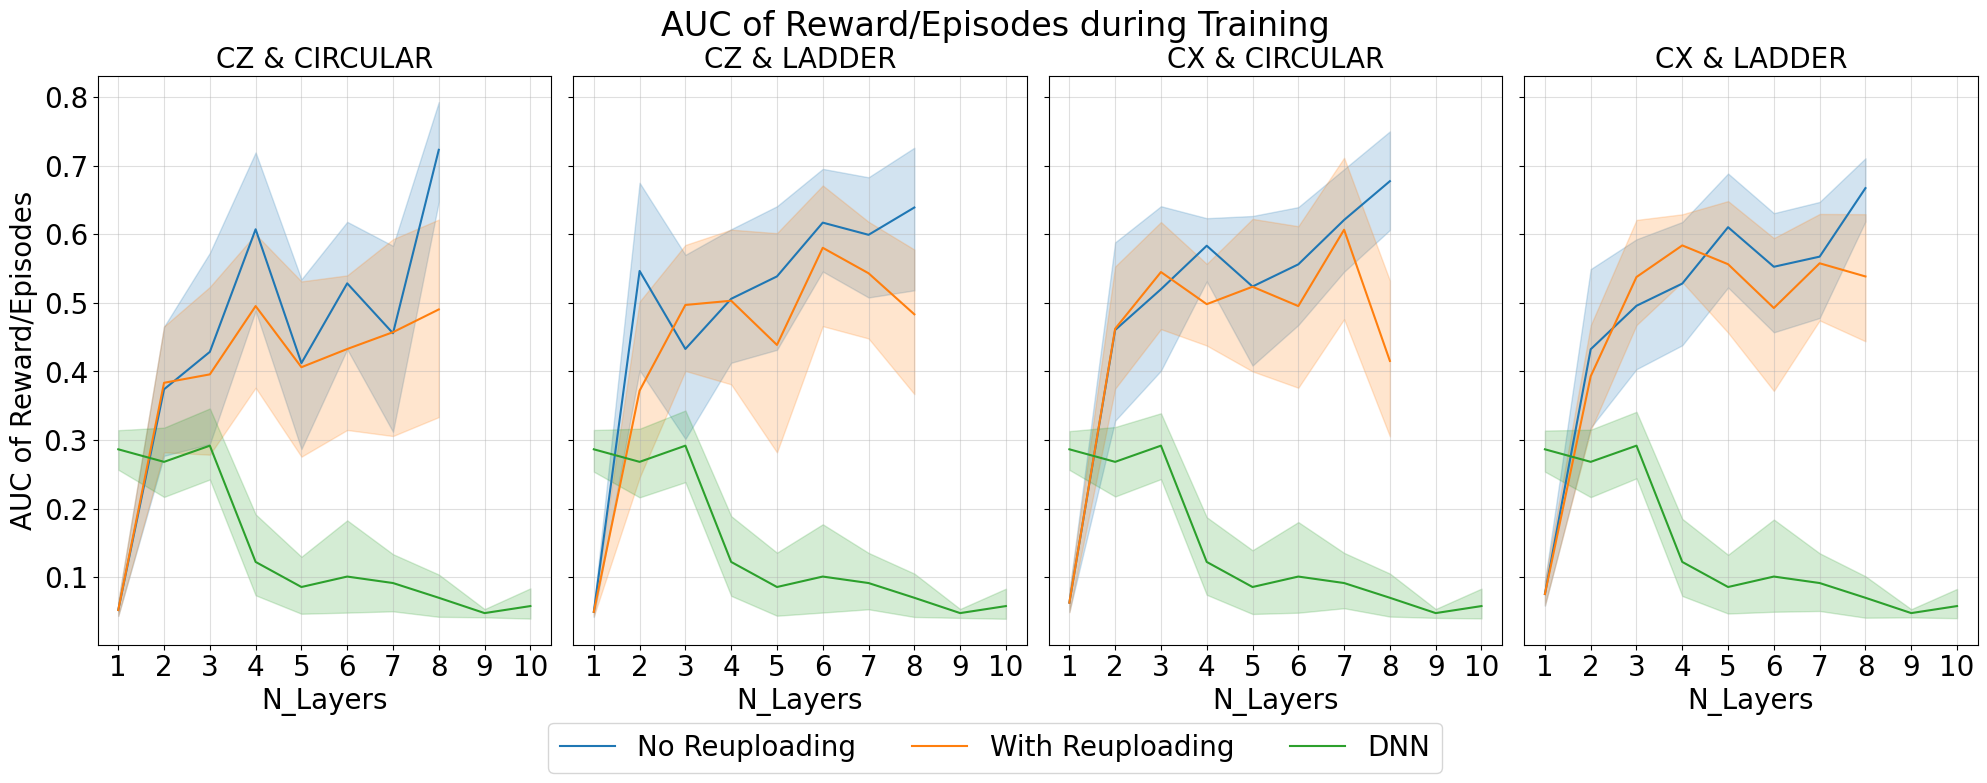

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(20, 7), sharey=True)

palette = {0: "C0", 1: "C1"}

LEGEND_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20
TICK_SIZE = 20

for cx in range(2):
    for ladder in range(2):
        ax_ = ax[cx * 2 + ladder]

        ax_.grid(alpha=0.4)

        # Plot VQC
        sns.lineplot(
            x="n_layers",
            y="AUC",
            hue="reuploading",
            data=df[(df["cx"] == cx) & (df["ladder"] == ladder)],
            markers=True,
            dashes=True,
            markersize=8,
            ax=ax_,
            palette=palette,
            legend=True,
        )

        #Plot DNN
        sns.lineplot(
            x="n_layers",
            y="AUC",
            data=df[df['is_classical'] == True], 
            markers=True,
            dashes=True,
            markersize=8,
            ax=ax_,
            color="C2",
            legend=True,
            label="DNN"
        )

        ax_.set(xticks=df["n_layers"].unique())

        #  ax_.set_title(f"CX = {bool(cx)}, LADDER = {bool(ladder)}", fontsize=BIGGER_SIZE)
        if bool(cx) and bool(ladder):
            ax_.set_title("CX & LADDER", fontsize=BIGGER_SIZE)
        elif bool(cx) and not bool(ladder):
            ax_.set_title("CX & CIRCULAR", fontsize=BIGGER_SIZE)
        elif not bool(cx) and bool(ladder):
            ax_.set_title("CZ & LADDER", fontsize=BIGGER_SIZE)
        else:
            ax_.set_title("CZ & CIRCULAR", fontsize=BIGGER_SIZE)
            
        ax_.set_xlabel("N_Layers", fontsize=MEDIUM_SIZE)
        ax_.set_ylabel("AUC of Reward/Episodes", fontsize=MEDIUM_SIZE)
        ax_.legend(fontsize=LEGEND_SIZE)
        ax_.tick_params(axis="both", which="major", labelsize=TICK_SIZE)
        
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


labels = ["No Reuploading", "With Reuploading", "DNN"]
fig.legend(lines, labels, loc="lower center", ncol=3, fontsize=LEGEND_SIZE, bbox_to_anchor=(0.5, -0.08))

# Remove all legends
for ax in fig.axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

fig.tight_layout()

# Add title
fig.suptitle("AUC of Reward/Episodes during Training", fontsize=BIGGER_SIZE+4, y=1.03)

# Save
fig.savefig(join(FIGURES_DIR, "AUC_RewEp.pdf"), bbox_inches="tight")

### Max Reward in Training

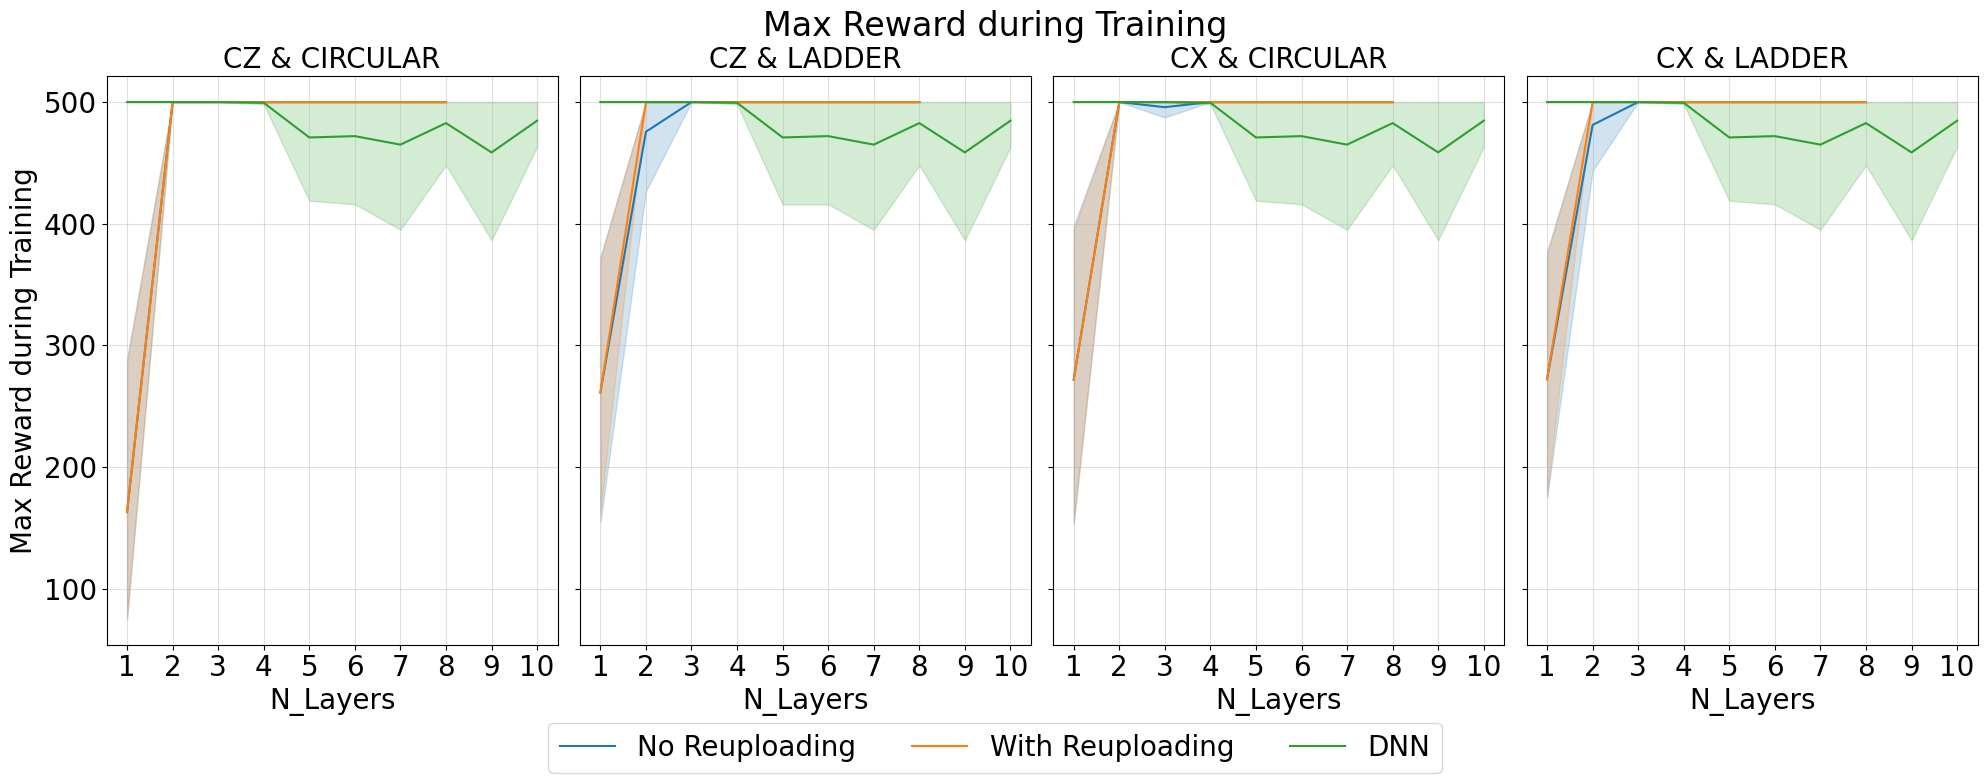

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(20, 7), sharey=True)

palette = {0: "C0", 1: "C1"}

LEGEND_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20
TICK_SIZE = 20

for cx in range(2):
    for ladder in range(2):
        ax_ = ax[cx*2+ladder]   

        ax_.grid(alpha=0.4)

        # Plot VQC
        sns.lineplot(
            x="n_layers",
            y="max_reward",
            hue="reuploading",
            data=df[(df["cx"] == cx) & (df["ladder"] == ladder)],
            markers=True,
            dashes=True,
            markersize=8,
            ax=ax_,
            palette=palette,
            legend=True,
        )

        # Plot DNN
        sns.lineplot(
            x="n_layers",
            y="max_reward",
            data=df[df['is_classical'] == True], 
            markers=True,
            dashes=True,
            markersize=8,
            ax=ax_,
            color="C2",
            legend=True,
            label="DNN"
        )

        ax_.set(xticks=df["n_layers"].unique())

        #  ax_.set_title(f"CX = {bool(cx)}, LADDER = {bool(ladder)}", fontsize=BIGGER_SIZE)
        if bool(cx) and bool(ladder):
            ax_.set_title("CX & LADDER", fontsize=BIGGER_SIZE)
        elif bool(cx) and not bool(ladder):
            ax_.set_title("CX & CIRCULAR", fontsize=BIGGER_SIZE)
        elif not bool(cx) and bool(ladder):
            ax_.set_title("CZ & LADDER", fontsize=BIGGER_SIZE)
        else:
            ax_.set_title("CZ & CIRCULAR", fontsize=BIGGER_SIZE)
            
        ax_.set_xlabel("N_Layers", fontsize=MEDIUM_SIZE)
        ax_.set_ylabel("Max Reward during Training", fontsize=MEDIUM_SIZE)
        ax_.legend(fontsize=LEGEND_SIZE)
        ax_.tick_params(axis="both", which="major", labelsize=TICK_SIZE)
        
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


labels = ["No Reuploading", "With Reuploading", "DNN"]
fig.legend(lines, labels, loc="lower center", ncol=3, fontsize=LEGEND_SIZE, bbox_to_anchor=(0.5, -0.08))

# Remove all legends
for ax in fig.axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

fig.tight_layout()

# Add title
fig.suptitle("Max Reward during Training", fontsize=BIGGER_SIZE+4, y=1.03)

# Save
fig.savefig(join(FIGURES_DIR, "AUC_RewEp.pdf"), bbox_inches="tight")

### Best Episode in Training

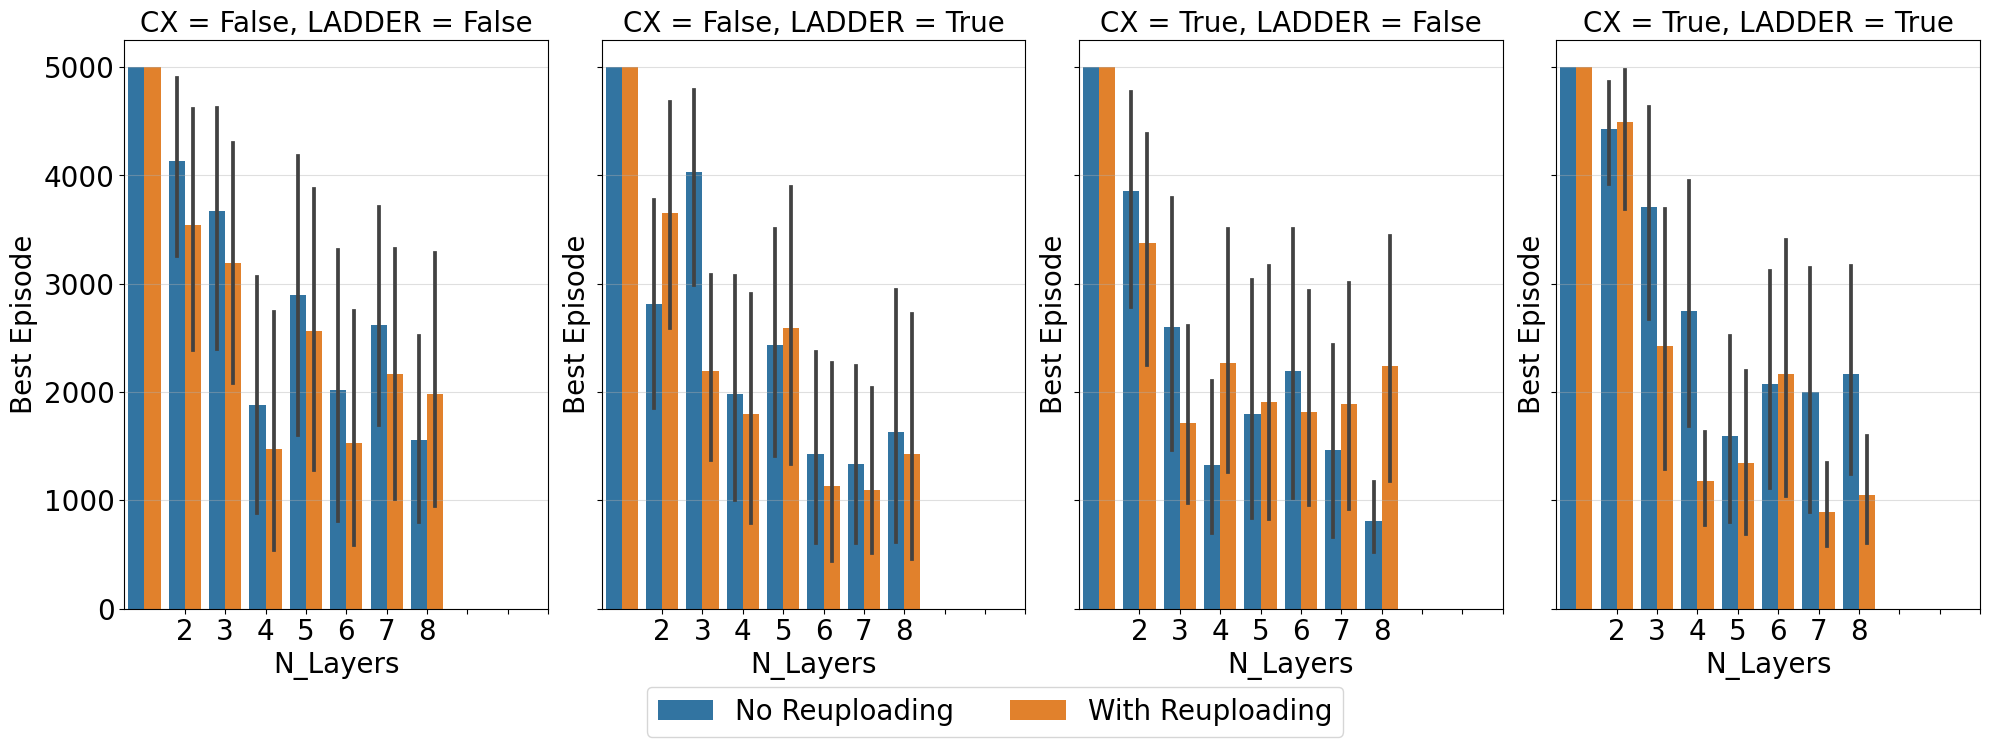

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(20, 7), sharey=True)

palette = {0: "C0", 1: "C1", 2: "C2"}

LEGEND_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20
TICK_SIZE = 20

for cx in range(2):
    for ladder in range(2):
        ax_ = ax[cx*2+ ladder]

        ax_.grid(alpha=0.4)

        # Plot barchart of done vs not done
        sns.barplot(
            x="n_layers",
            y="episode",
            hue="reuploading",
            data=pd.concat([df[(df["cx"] == cx) & (df["ladder"] == ladder)]]), #df_DNN]),
            ax=ax_,
            palette=palette,
            #legend=True,
        )

        ax_.set(xticks=df["n_layers"].unique())
        ax_.set_title(f"CX = {bool(cx)}, LADDER = {bool(ladder)}", fontsize=BIGGER_SIZE)
        ax_.set_xlabel("N_Layers", fontsize=MEDIUM_SIZE)
        ax_.set_ylabel("Best Episode", fontsize=MEDIUM_SIZE)
        ax_.legend(fontsize=LEGEND_SIZE)
        ax_.tick_params(axis="both", which="major", labelsize=TICK_SIZE)
        
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


labels = ["No Reuploading", "With Reuploading", "DNN"]
fig.legend(lines, labels, loc="lower center", ncol=3, fontsize=LEGEND_SIZE, bbox_to_anchor=(0.5, -0.08))

# Remove all legends
for ax in fig.axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

fig.tight_layout()
fig.savefig(join(FIGURES_DIR, "BestEp.pdf"), bbox_inches="tight")

### \# Wins in Benchmark

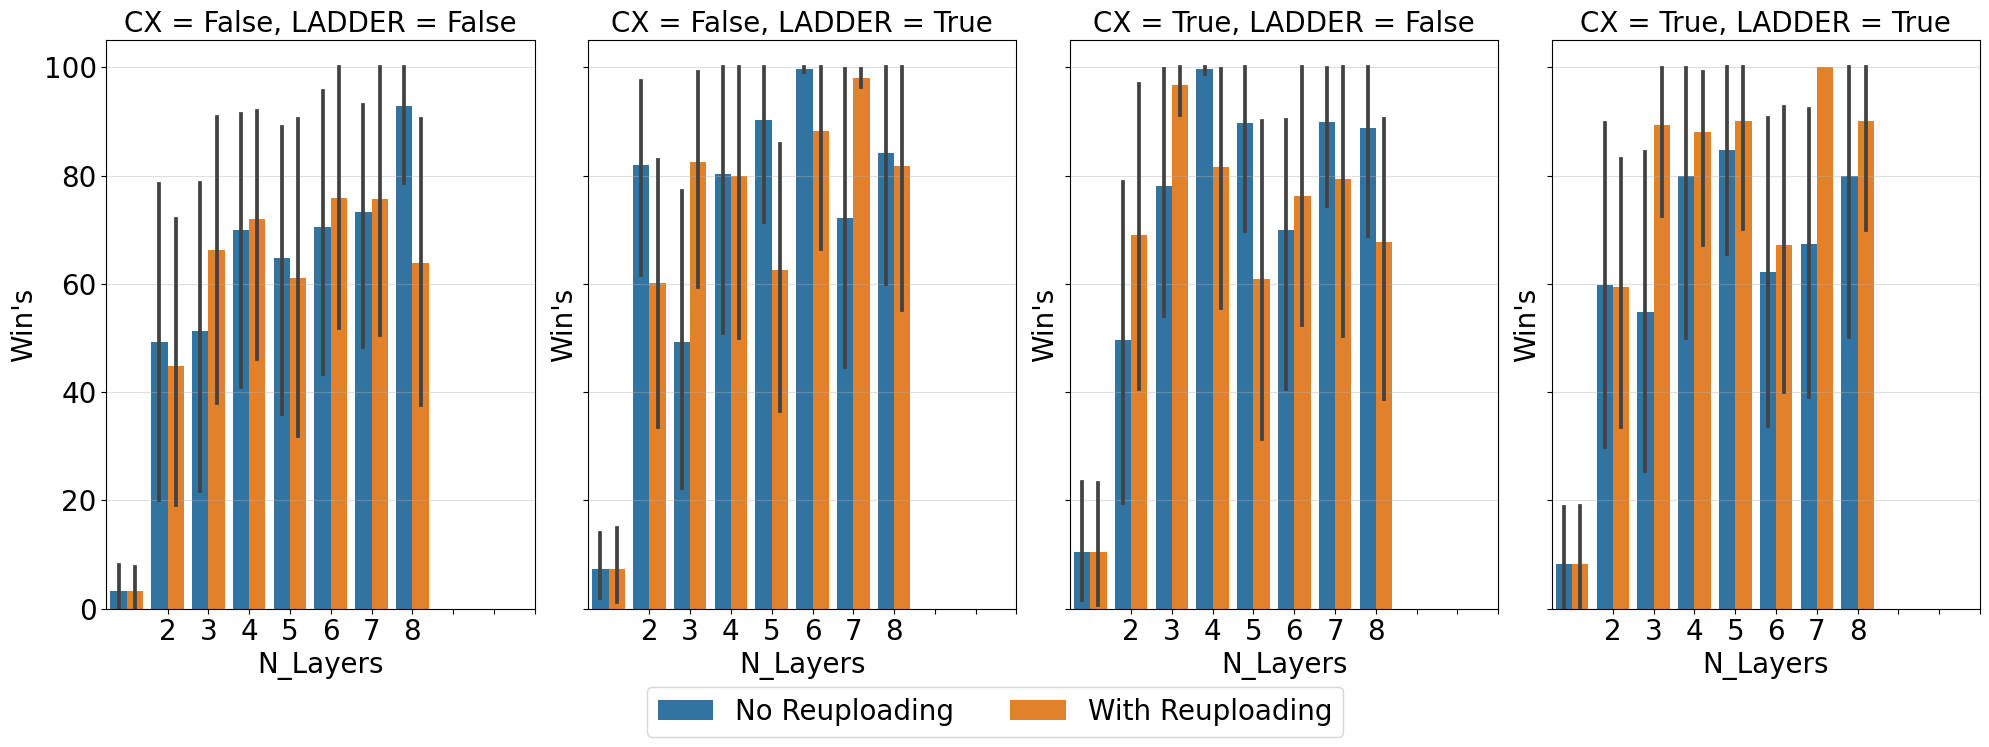

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(20, 7), sharey=True)

palette = {0: "C0", 1: "C1", 2: "C2"}

LEGEND_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20
TICK_SIZE = 20


for cx in range(2):
    for ladder in range(2):
        ax_ = ax[cx*2+ ladder]

        ax_.grid(alpha=0.4)

        # Plot barchart of done vs not done
        sns.barplot(
            x="n_layers",
            y="benchmark_wins",
            hue="reuploading",
            data=pd.concat([df[(df["cx"] == cx) & (df["ladder"] == ladder)]]),# df_DNN]),
            ax=ax_,
            palette=palette,
            #legend=True,
        )

        ax_.set(xticks=df["n_layers"].unique())
        ax_.set_title(f"CX = {bool(cx)}, LADDER = {bool(ladder)}", fontsize=BIGGER_SIZE)
        ax_.set_xlabel("N_Layers", fontsize=MEDIUM_SIZE)
        ax_.set_ylabel("Win's", fontsize=MEDIUM_SIZE)
        ax_.legend(fontsize=LEGEND_SIZE)
        ax_.tick_params(axis="both", which="major", labelsize=TICK_SIZE)
        
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


labels = ["No Reuploading", "With Reuploading", "DNN"]
fig.legend(lines, labels, loc="lower center", ncol=3, fontsize=LEGEND_SIZE, bbox_to_anchor=(0.5, -0.08))

# Remove all legends
for ax in fig.axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

fig.tight_layout()


## Benchmark Reward

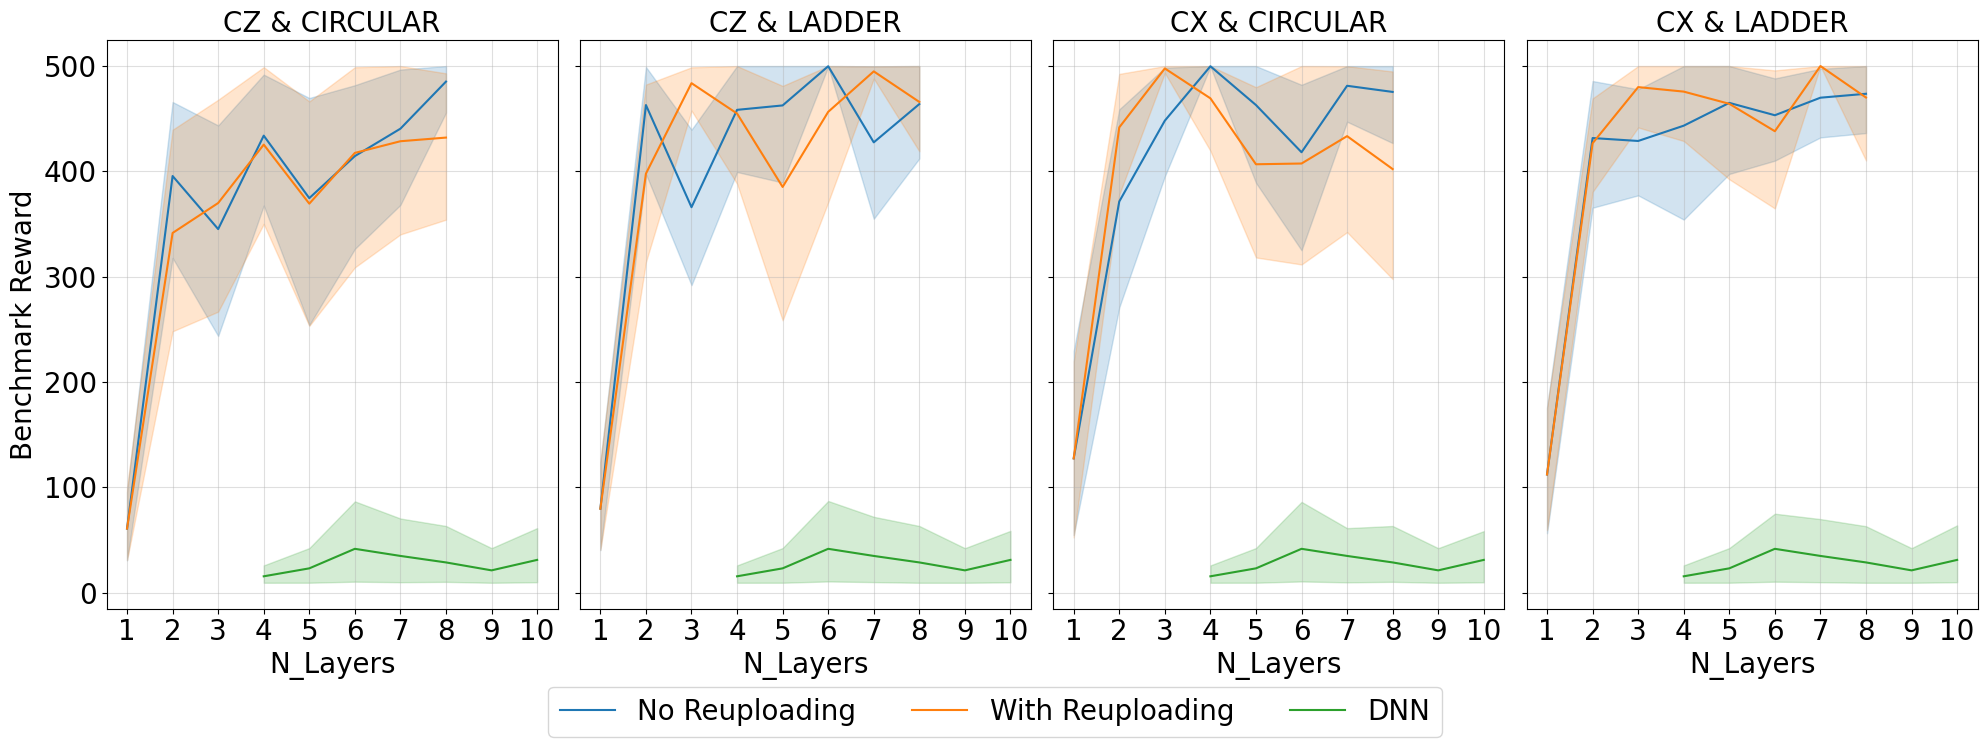

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(20, 7), sharey=True)

palette = {0: "C0", 1: "C1", 2: "C2"}

LEGEND_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20
TICK_SIZE = 20

for cx in range(2):
    for ladder in range(2):
        ax_ = ax[cx*2+ ladder]

        # Grid with alpha = 0.5
        ax_.grid(alpha=0.4)

        sns.lineplot(
            x="n_layers",
            y="benchmark_rewards",
            hue="reuploading",
            data=pd.concat([df[(df["cx"] == cx) & (df["ladder"] == ladder)]]),#, df_DNN]),
            markers=True,
            dashes=True,
            markersize=8,
            ax=ax_,
            palette=palette,
            legend=True,
        )

        # Plot DNN
        sns.lineplot(
            x="n_layers",
            y="benchmark_rewards",
            data=df[df['is_classical'] == True], 
            markers=True,
            dashes=True,
            markersize=8,
            ax=ax_,
            color="C2",
            legend=True,
            label="DNN"
        )

        ax_.set(xticks=df["n_layers"].unique())
        if bool(cx) and bool(ladder):
            ax_.set_title("CX & LADDER", fontsize=BIGGER_SIZE)
        elif bool(cx) and not bool(ladder):
            ax_.set_title("CX & CIRCULAR", fontsize=BIGGER_SIZE)
        elif not bool(cx) and bool(ladder):
            ax_.set_title("CZ & LADDER", fontsize=BIGGER_SIZE)
        else:
            ax_.set_title("CZ & CIRCULAR", fontsize=BIGGER_SIZE)
        ax_.set_xlabel("N_Layers", fontsize=MEDIUM_SIZE)
        ax_.set_ylabel("Benchmark Reward", fontsize=MEDIUM_SIZE)
        ax_.legend(fontsize=LEGEND_SIZE)
        ax_.tick_params(axis="both", which="major", labelsize=TICK_SIZE)
        
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


labels = ["No Reuploading", "With Reuploading", "DNN"]
fig.legend(lines, labels, loc="lower center", ncol=3, fontsize=LEGEND_SIZE, bbox_to_anchor=(0.5, -0.08))

# Remove all legends
for ax in fig.axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

fig.tight_layout()

# Save figure
fig.savefig(join(FIGURES_DIR, "benchmark_reward.pdf"), dpi=300, bbox_inches="tight")


In [10]:
df

,reuploading,cx,ladder,n_layers,seed,batch_size,lr,n_episodes,max_steps,gamma,...,last_reward,mean_reward,std_reward,max_reward,min_reward,mean_5_reward,AUC,benchmark_rewards,benchmark_wins,best_score
0,0,0,1,8,4,16,0.001,5000,500,0.99,...,24.0,93.643000,138.023236,500.0,8.0,42.0,0.187286,344.3300,41,NaN
1,1,1,0,5,5,16,0.001,5000,500,0.99,...,10.0,82.079800,96.219737,500.0,8.0,9.6,0.164160,149.3000,2,NaN
2,0,1,1,6,10,16,0.001,5000,500,0.99,...,500.0,257.412046,159.900098,500.0,9.0,500.0,0.514824,500.0000,100,NaN
3,0,1,1,3,10,16,0.001,5000,500,0.99,...,232.0,224.310800,101.643844,500.0,8.0,239.2,0.448622,409.3100,1,NaN
4,0,0,1,2,1,16,0.001,5000,500,0.99,...,500.0,390.704843,173.840217,500.0,8.0,500.0,0.781410,499.5500,99,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,None,None,None,5,8,16,0.001,5000,500,0.99,...,10.0,21.671334,40.115150,469.0,8.0,9.2,0.043343,9.3542,0,469.0
736,None,None,None,4,8,16,0.001,5000,500,0.99,...,9.0,36.567914,83.902904,500.0,8.0,9.4,0.073136,9.3598,0,500.0
737,None,None,None,7,6,16,0.001,5000,500,0.99,...,10.0,29.708542,40.590920,500.0,8.0,10.4,0.059417,10.1508,0,500.0
738,None,None,None,1,2,16,0.001,5000,500,0.99,...,389.0,158.201987,167.573584,500.0,8.0,336.6,0.316404,NaN,None,500.0


/tmp/ipykernel_3074213/3974665397.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DNN["Percent of wins"] = df_DNN["benchmark_wins"]/100


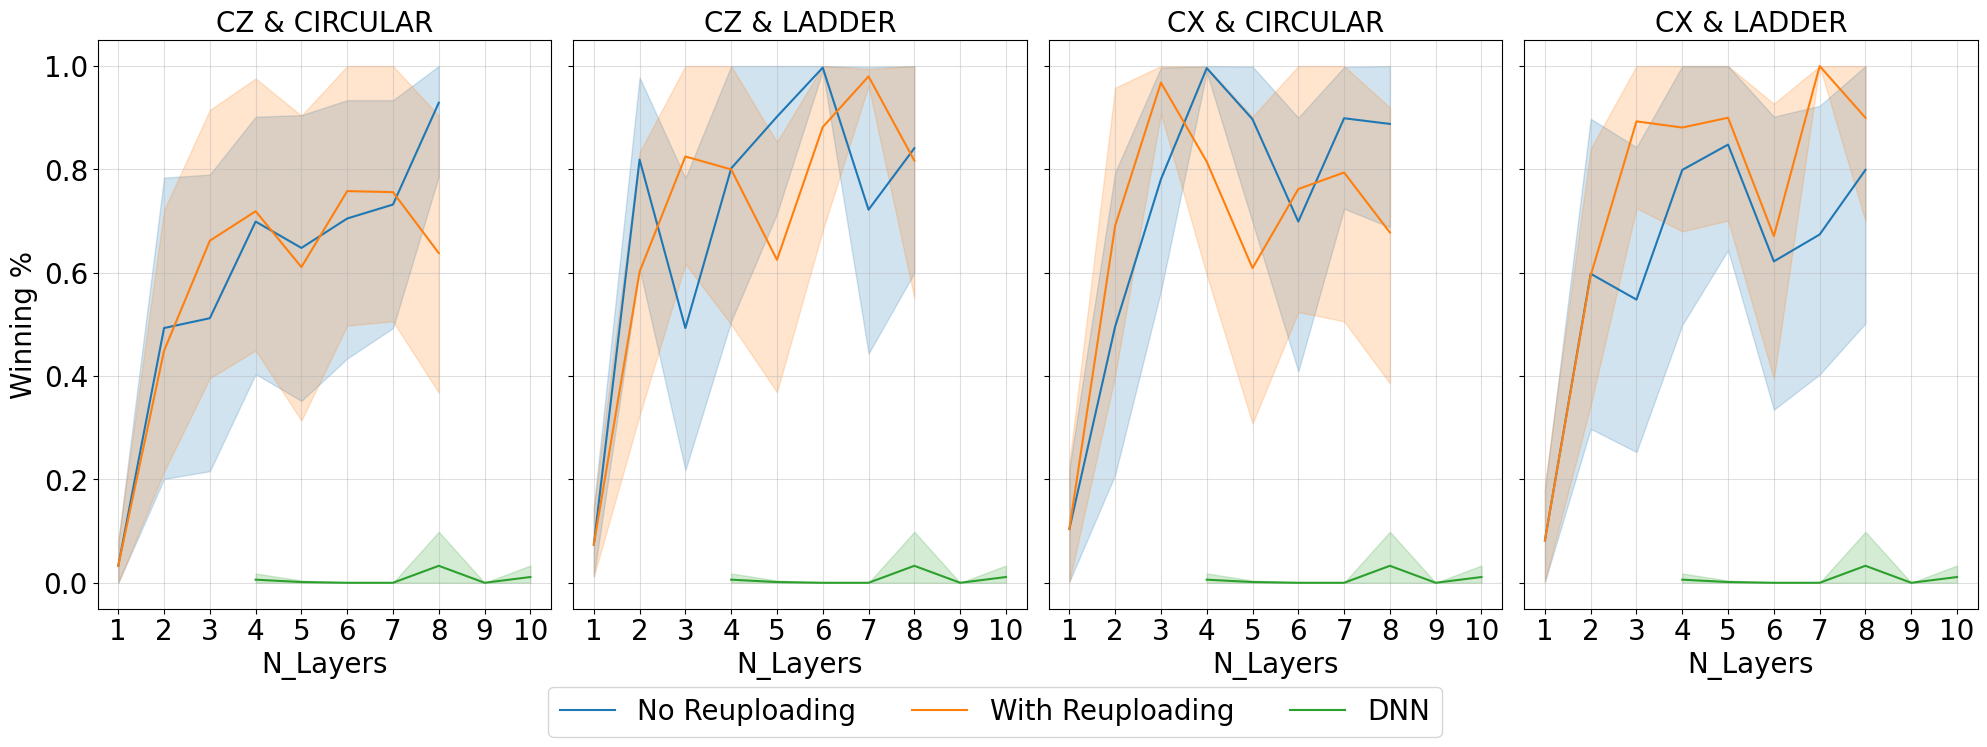

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(20, 7), sharey=True)

palette = {0: "C0", 1: "C1", 2: "C2"}

LEGEND_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20
TICK_SIZE = 20

# Calculate the percentage of wins
df["Percent of wins"] = df["benchmark_wins"]/100
df_DNN["Percent of wins"] = df_DNN["benchmark_wins"]/100



for cx in range(2):
    for ladder in range(2):
        ax_ = ax[cx*2+ladder]

        ax_.grid(alpha=0.4)

        sns.lineplot(
            x="n_layers",
            y="Percent of wins",
            hue="reuploading",
            data=pd.concat([df[(df["cx"] == cx) & (df["ladder"] == ladder)]]),#, df_DNN]),
            markers=True,
            dashes=True,
            markersize=8,
            ax=ax_,
            palette=palette,
            legend=True,
        )

        # Plot DNN
        sns.lineplot(
            x="n_layers",
            y="Percent of wins",
            data=df[df['is_classical'] == True], 
            markers=True,
            dashes=True,
            markersize=8,
            ax=ax_,
            color="C2",
            legend=True,
            label="DNN"
        )

        ax_.set(xticks=df["n_layers"].unique())
        if bool(cx) and bool(ladder):
            ax_.set_title("CX & LADDER", fontsize=BIGGER_SIZE)
        elif bool(cx) and not bool(ladder):
            ax_.set_title("CX & CIRCULAR", fontsize=BIGGER_SIZE)
        elif not bool(cx) and bool(ladder):
            ax_.set_title("CZ & LADDER", fontsize=BIGGER_SIZE)
        else:
            ax_.set_title("CZ & CIRCULAR", fontsize=BIGGER_SIZE)
        ax_.set_xlabel("N_Layers", fontsize=MEDIUM_SIZE)
        ax_.set_ylabel("Winning %", fontsize=MEDIUM_SIZE)
        ax_.legend(fontsize=LEGEND_SIZE)
        ax_.tick_params(axis="both", which="major", labelsize=TICK_SIZE)
        
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


labels = ["No Reuploading", "With Reuploading", "DNN"]
fig.legend(lines, labels, loc="lower center", ncol=3, fontsize=LEGEND_SIZE, bbox_to_anchor=(0.5, -0.08))

# Remove all legends
for ax in fig.axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

fig.tight_layout()

# Save figure
fig.savefig(join(FIGURES_DIR, "benchmark_percentage.pdf"), dpi=300, bbox_inches="tight")

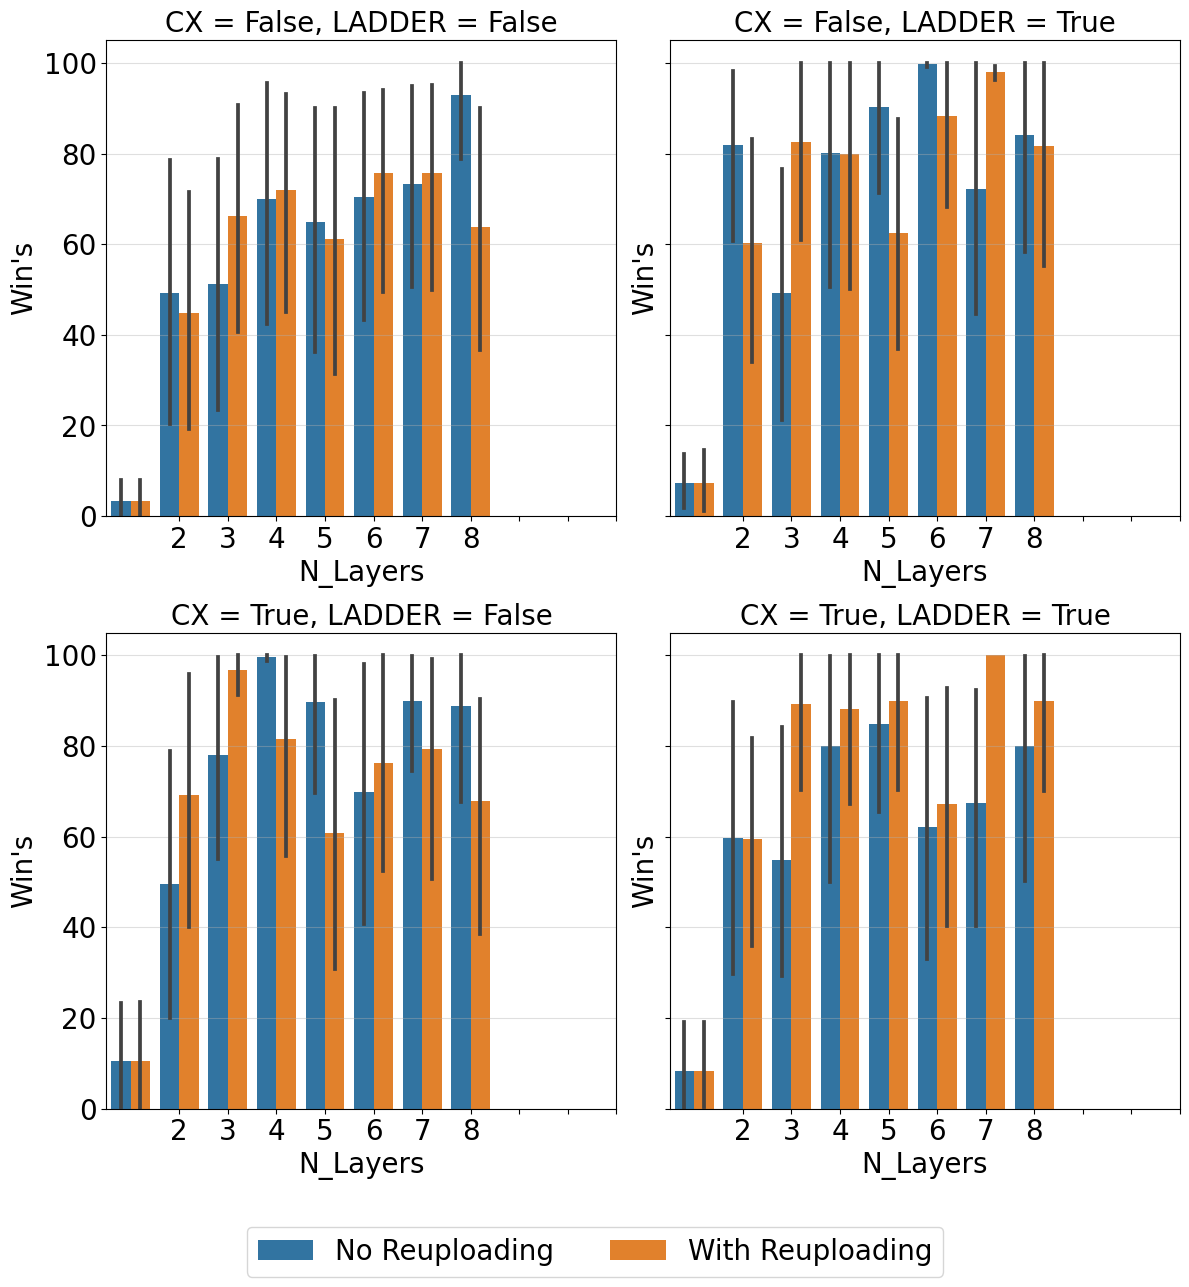

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

palette = {0: "C0", 1: "C1", 2: "C2"}

LEGEND_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20
TICK_SIZE = 20

for cx in range(2):
    for ladder in range(2):
        ax_ = ax[cx, ladder]

        ax_.grid(alpha=0.4)

        # Plot barchart of done vs not done
        sns.barplot(
            x="n_layers",
            y="benchmark_wins",
            hue="reuploading",
            data=pd.concat([df[(df["cx"] == cx) & (df["ladder"] == ladder)]]),#, df_DNN]),
            ax=ax_,
            palette=palette,
            #legend=True,
        )

        ax_.set(xticks=df["n_layers"].unique())
        ax_.set_title(f"CX = {bool(cx)}, LADDER = {bool(ladder)}", fontsize=BIGGER_SIZE)
        ax_.set_xlabel("N_Layers", fontsize=MEDIUM_SIZE)
        ax_.set_ylabel("Win's", fontsize=MEDIUM_SIZE)
        ax_.legend(fontsize=LEGEND_SIZE)
        ax_.tick_params(axis="both", which="major", labelsize=TICK_SIZE)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


labels = ["No Reuploading", "With Reuploading", "DNN"]
fig.legend(lines, labels, loc="lower center", ncol=3, fontsize=LEGEND_SIZE, bbox_to_anchor=(0.5, -0.08))

# Remove all legends
for ax in fig.axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

fig.tight_layout()
